# What are the theoretical maximum performance metrics?

AUTHOR: E Karvelis
DATE: 9/9/2023

Given that the TIS $\mathrm{k}_{cat}$ calculations are noisy, what values are even feasible for the various performance metrics that we consider? 

Here, we are mainly concerned with metrics for regression: Pearson correlation, Spearman rank correlation, and RMSE

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

np.random.seed(333)

In [2]:
# read data
df = pd.read_csv('/data/karvelis03/dl_kcat/input/variants_summary.csv')
df = df.loc[df['TIS raw k'].to_numpy(str) != 'nan (nan)']
# display (df)

k_avgs = np.array([x.split('(')[0] for x in df['TIS raw k']], dtype=float) 
k_errs = np.array([x.split('(')[-1].split(')')[0] for x in df['TIS raw k']], dtype=float)

print (k_avgs)
print (k_errs)

[1.67e-12 1.78e-13 8.58e-15 8.51e-15 6.11e-15 5.40e-15 8.48e-15 8.92e-14
 2.26e-14 6.59e-16 6.42e-15 9.08e-16 1.60e-15 5.22e-15 1.33e-15 4.78e-16
 2.87e-16 1.02e-14 8.41e-16 7.61e-16 4.13e-16 5.39e-16 1.64e-16 7.88e-16
 1.11e-15 9.52e-17 2.32e-16 4.44e-17 5.76e-17 8.96e-17 7.14e-17 7.65e-17
 4.93e-17 3.69e-17 4.47e-17 3.17e-17 2.20e-16 1.25e-16 5.92e-17 2.51e-17
 4.40e-17 1.64e-17 6.40e-17 8.60e-17 1.26e-17 7.48e-18 3.77e-18 5.84e-18
 9.32e-18 3.89e-18 6.24e-17 4.79e-19 3.50e-19 2.86e-19 1.23e-19]
[1.4e-12 1.5e-13 3.4e-15 3.5e-15 3.0e-15 3.7e-15 4.7e-15 6.0e-14 9.2e-15
 1.5e-16 4.5e-15 4.5e-16 7.1e-16 3.5e-15 7.7e-16 2.0e-16 1.4e-16 7.5e-15
 6.1e-16 4.0e-16 2.3e-16 2.8e-16 5.4e-17 5.4e-16 9.1e-16 3.9e-17 1.2e-16
 1.5e-17 3.4e-17 3.8e-17 3.2e-17 4.0e-17 2.2e-17 1.6e-17 3.5e-17 1.3e-17
 2.1e-16 8.5e-17 4.7e-17 1.3e-17 2.5e-17 1.3e-17 6.2e-17 7.8e-17 8.3e-18
 4.6e-18 2.4e-18 3.6e-18 8.1e-18 3.0e-18 5.0e-17 1.4e-19 1.2e-19 1.1e-19
 9.2e-20]


In [15]:

class Experiment:
    # Bootstraps sets of kcat by sampling new values from 
    # normal distributions with mean = average and 
    # standard deviation = SEM

    def __init__(self, avgs, errs, n=10000, seed=333):
        # avgs -- the average values of the originally computed kcat's
        # errs -- the SEM associated with each computed kcat 
        # n    -- the number of experiments to run. 1 experiment 
        #         equals one resampling of noisy kcat values
        # seed -- random seed
        
        np.random.seed(seed)

        self.avgs = avgs
        self.errs = errs
        self.sampler = np.random.normal(loc=self.avgs, scale=self.errs)
        self.n = n
        self.samples = [[None]] # will later hold the resampled kcat values
        self.res = {} # dictionary to store results from the experiments
    
    def pos_sample(self):
        # This continues resampling kcat values from their respective
        # normal distributions until a set of ONLY positive values
        # is sampled. This is required because kcat CANNOT be 
        # negative.
        s = np.random.normal(loc=self.avgs, scale=self.errs)

        return(s if np.sum(s>0)==s.shape[0] else self.pos_sample())

    def sample(self):
        # For each TIS-computed kcat, resamples from normal distribution with 
        # mean = average and stddev = SEM. If the sampled value is negative, 
        # it is rounded up to 0
        # s = np.max(np.vstack((np.zeros(self.avgs.shape[0]) + 1e-30, np.random.normal(loc=self.avgs, scale=self.errs))), axis=0)
        # s = np.max(np.vstack((self.avgs, np.random.normal(loc=self.avgs, scale=self.errs))), axis=0)
        s = self.pos_sample()
        s = np.log10(s)
        return s

    def populate_samples(self):
        # Resamples one set of kcat values for each experiment, 
        # and each experiment corresponds to one row of values
        # written to self.samples
        samples = []
        for i in range(self.n):
            samples.append(self.sample())

        print (f'len(samples): {len(samples)}')
        self.samples = np.array(samples)

    @staticmethod
    def rmse(a1, a2):
        # calculates the RMSE between arrays a1 and a2
        # print (a1.shape)
        # print (a2.shape)
        # print ((a1-a2).shape)
        # print (((a1-a2)**2).shape)
        # print (np.mean((a1 - a2)**2))
        # print (np.mean((a1 - a2)**2)**0.5)
        return np.mean((a1 - a2)**2)**0.5

    def run(self):
        if self.samples[0][0] == None:
            self.populate_samples()
        
        print (f'self.samples.shape: {self.samples.shape}')

        self.res['spearman'] = np.array([spearmanr(self.samples[i], np.log10(self.avgs))[0] for i in range(self.samples.shape[0])])
        self.res['pearson'] = np.array([pearsonr(self.samples[i], np.log10(self.avgs))[0] for i in range(self.samples.shape[0])])
        self.res['RMSE'] = np.array([self.rmse(self.samples[i], np.log10(self.avgs)) for i in range(self.samples.shape[0])])

    def plot_samples(self):
        if self.samples[0][0] == None:
            self.populate_samples()

        fig, axes = plt.subplots(11,5,figsize=(20,50))
        for i in range(exp.avgs.shape[0]):
            ax = axes.flatten()[i]
            ax.hist(exp.samples[:,i])
            ax.axvline(np.log10(exp.avgs[i]), color='k')

    def plot_res(self):
        for metric in ['pearson', 'spearman', 'RMSE']:
            metric_avg = np.mean(exp.res[metric])
            metric_std = np.std(exp.res[metric], ddof=1) #/ (exp.res[metric].shape[0]**0.5)
            plt.figure(figsize=(5,2))
            plt.hist(exp.res[metric])
            plt.title(f'{metric}: {metric_avg:.3f} +/- {metric_std:.3f}')
            plt.show()

exp = Experiment(k_avgs, k_errs, seed=2019991)
exp.run()

len(samples): 10000
self.samples.shape: (10000, 55)


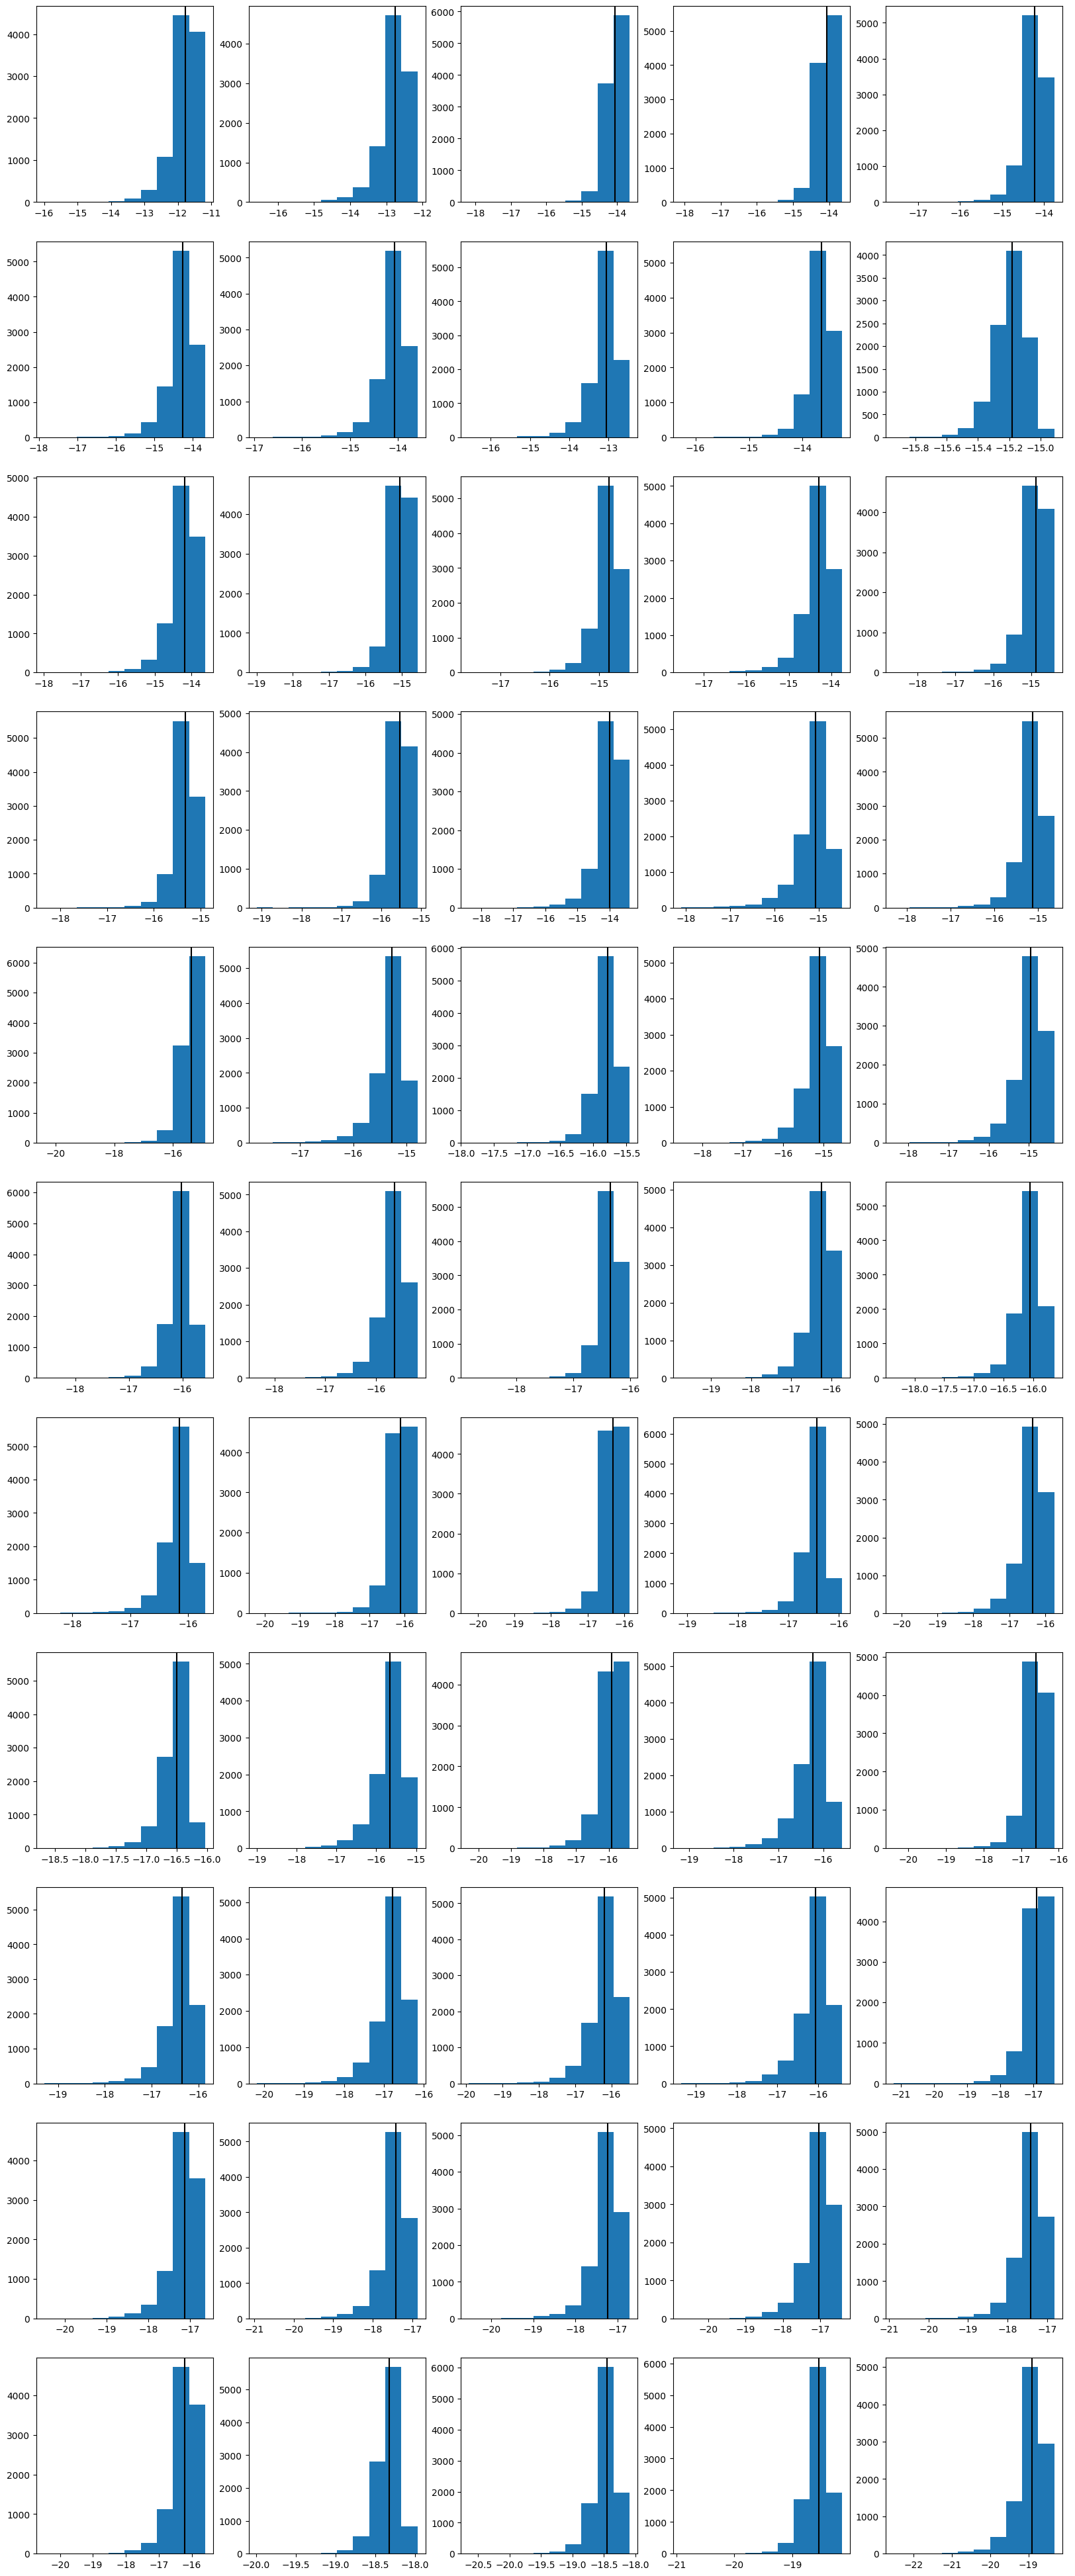

In [16]:
exp.plot_samples()

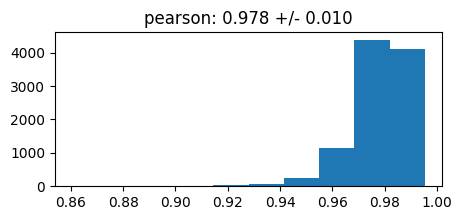

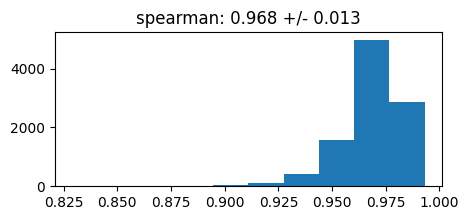

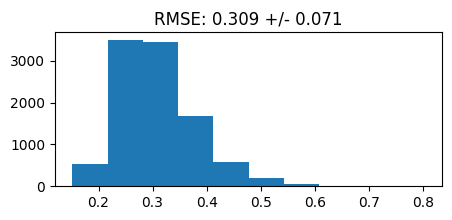

In [17]:
exp.plot_res()